## Introduction:

This is an implementation for a stock prediction task using LSTM .. 

Reference ==> 
https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo/blob/master/stockdemo.ipynb

In [19]:
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore")

import time #helper libraries

In [6]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    print 'yo'
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in xrange(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()

In [8]:
def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'r').read()
    data = f.split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) 
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  
    return [x_train, y_train, x_test, y_test]

In [9]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [10]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print "Compilation Time : ", time.time() - start
    return model

In [11]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

In [12]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in xrange(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

In [13]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in xrange(len(data)/prediction_len):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in xrange(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [22]:
#Step 1 Load Data
X_train, y_train, X_test, y_test = load_data('sp500.csv', 50, True)

In [25]:
X_train

array([[[ 0.        ],
        [-0.00657283],
        [-0.00040733],
        ..., 
        [ 0.05835446],
        [ 0.05707029],
        [ 0.05889984]],

       [[ 0.        ],
        [ 0.00227055],
        [ 0.00854144],
        ..., 
        [-0.02852791],
        [-0.03287585],
        [-0.04435198]],

       [[ 0.        ],
        [-0.01723348],
        [-0.01350585],
        ..., 
        [-0.04278654],
        [-0.04001338],
        [-0.04852202]],

       ..., 
       [[ 0.        ],
        [-0.00291359],
        [-0.00852186],
        ..., 
        [ 0.06547006],
        [ 0.0701436 ],
        [ 0.06716046]],

       [[ 0.        ],
        [ 0.01204922],
        [-0.01767446],
        ..., 
        [-0.05719728],
        [-0.08069665],
        [-0.08585585]],

       [[ 0.        ],
        [-0.01197661],
        [-0.00295617],
        ..., 
        [-0.0037762 ],
        [ 0.00278408],
        [ 0.00294603]]])

In [26]:
y_train

array([ 0.04449765, -0.05497081, -0.03611462, ...,  0.08588475,
       -0.11245068,  0.01212843])

In [27]:
X_test, y_test

(array([[[  0.00000000e+00],
         [  5.14346191e-06],
         [  1.11707103e-02],
         ..., 
         [  5.86539766e-02],
         [  5.84022033e-02],
         [  4.10963023e-02]],
 
        [[  0.00000000e+00],
         [  1.11655094e-02],
         [  9.58287384e-03],
         ..., 
         [  5.83967595e-02],
         [  4.10909474e-02],
         [  4.58130122e-02]],
 
        [[  0.00000000e+00],
         [ -1.56515980e-03],
         [ -1.66675378e-02],
         ..., 
         [  2.95949948e-02],
         [  3.42649175e-02],
         [  1.74957729e-02]],
 
        ..., 
        [[  0.00000000e+00],
         [  2.05178759e-04],
         [ -3.50228952e-03],
         ..., 
         [  5.92367277e-02],
         [  5.95786330e-02],
         [  5.83086832e-02]],
 
        [[  0.00000000e+00],
         [ -3.70670775e-03],
         [  2.29048363e-03],
         ..., 
         [  5.93612746e-02],
         [  5.80915853e-02],
         [  5.97911018e-02]],
 
        [[  0.00000000e+00

In [28]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print 'compilation time : ', time.time() - start

compilation time :  0.0107572078705


In [29]:
#Step 3 Train the model
model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=1,
    validation_split=0.05)

Train on 3523 samples, validate on 186 samples
Epoch 1/1
3523/3523 [==============================] - 8s - loss: 0.0023 - val_loss: 0.0013


yo


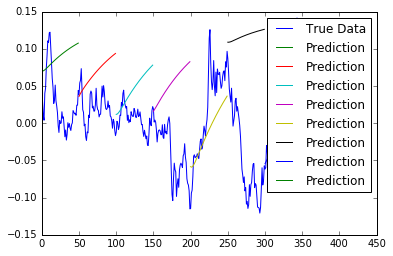

In [32]:
#Step 4 - Plot the predictions!
predictions = predict_sequences_multiple(model, X_test, 50, 50)
plot_results_multiple(predictions, y_test, 50)